In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r"C:\Users\nepim\OneDrive - Politecnico di Torino\Documents\GitHub\ICTforSmartMobilty_project\lab3\Unipol_dataset_lab3.csv")
data_f_dist = data[data["total_distance"] > 0.0]#distances equal to 0 are an outlier
print(data_f_dist.shape)
data_f_dist = data_f_dist[~((data_f_dist["total_distance"] <0.1) & (data_f_dist["road"] == "A"))]#removes 50ish trips


(1249353, 7)


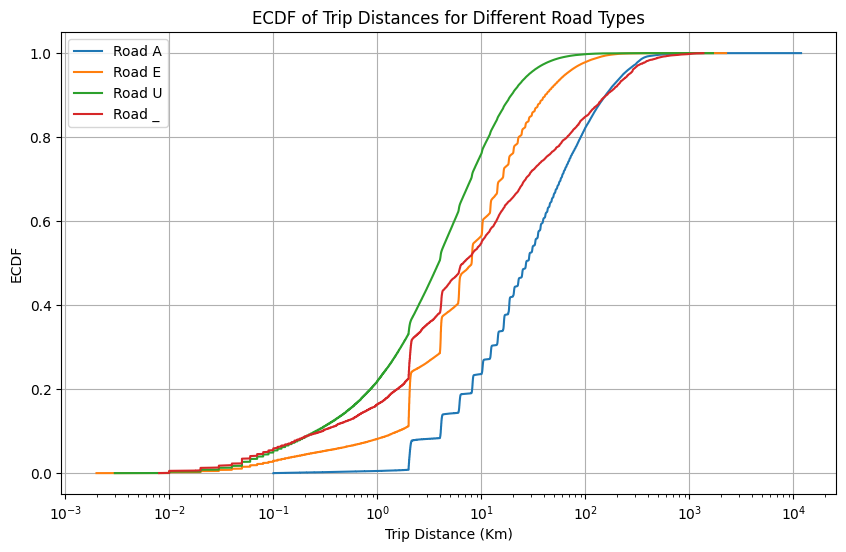

In [9]:
grouped = data_f_dist.groupby("road")
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(10, 6))

for road, group in grouped:
    x, y = ecdf(group["total_distance"])
    plt.semilogx(x, y, label=f"Road {road}")

plt.xlabel("Trip Distance (Km)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Distances for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()

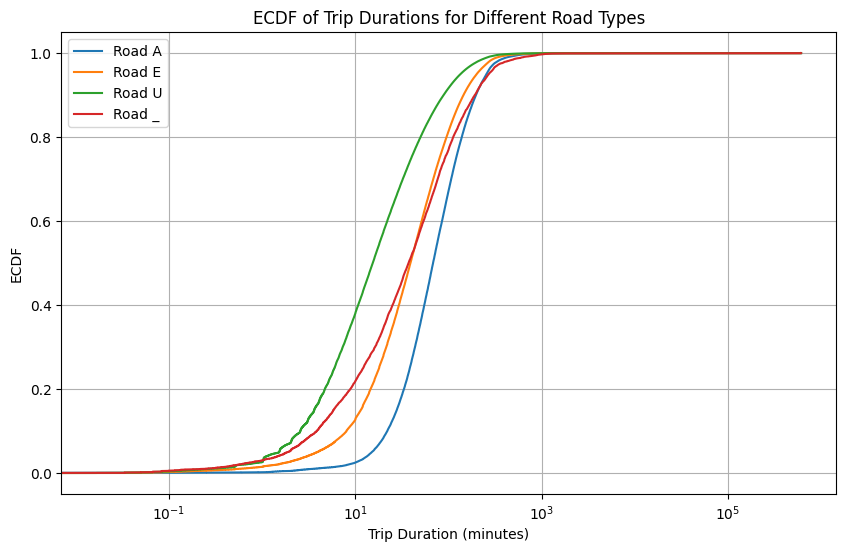

In [10]:

data_f_dist["start_time"] = pd.to_datetime(data_f_dist["start_time"])
data_f_dist["stop_time"] = pd.to_datetime(data_f_dist["stop_time"])
data_f_dist["trip_duration"] = (data_f_dist["stop_time"] - data_f_dist["start_time"]).dt.total_seconds() / 60.0 
grouped = data_f_dist.groupby("road")

plt.figure(figsize=(10, 6))
for road, group in grouped:
    x, y = ecdf(group["trip_duration"])
    plt.semilogx(x, y, label=f"Road {road}")

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Durations for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()

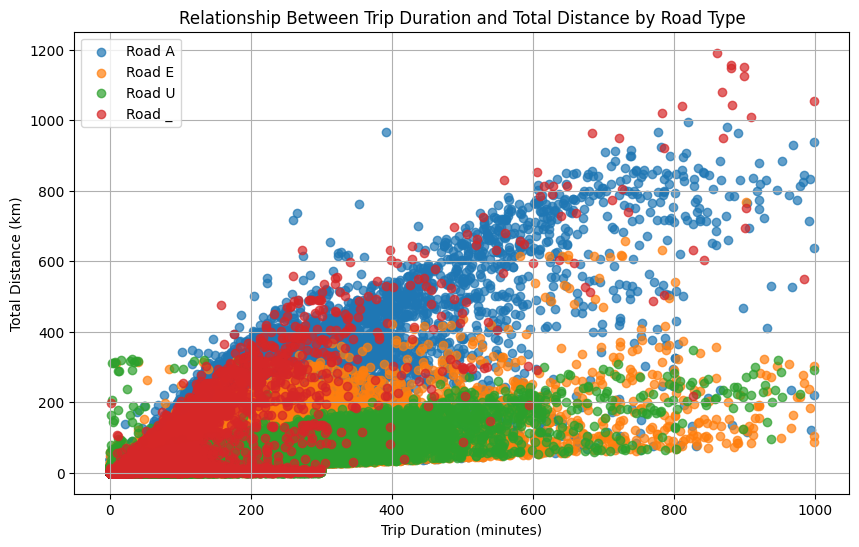

In [11]:
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 10) & (data_f_dist["trip_duration"] > 600))]#removes 100ish trips
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 5) & (data_f_dist["trip_duration"] > 300))]#removes 50ish trips

data_f_dist_avg_dur = data_f_dist_avg[data_f_dist_avg['trip_duration'] < 1000]#remove duration grater than 1000 minutes
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist_avg_dur.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()

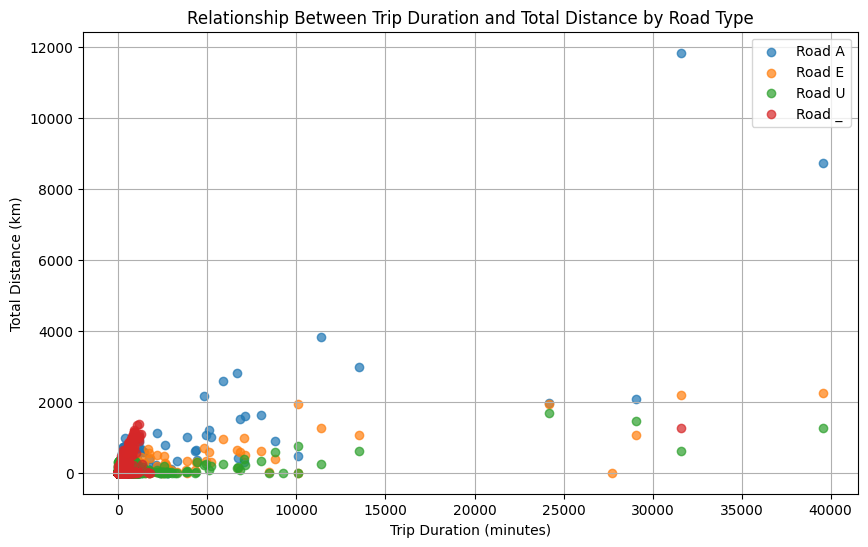

In [12]:
#no filter

data_f_dist = data_f_dist[data_f_dist['trip_duration'] < 100000]#remove duration grate than 24 hours
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
nonFiltered_count = data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips before filtering: {nonFiltered_count}")

Number of trips before filtering: 966000


In [14]:
fil_dist_avg_dur_count = data_f_dist_avg_dur.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips after filtering for average distance and duration: {fil_dist_avg_dur_count}")

Number of trips after filtering for average distance and duration: 827886


In [15]:
data_f_dist.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]


828117

# Task 1

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r"C:\Users\nepim\OneDrive - Politecnico di Torino\Documents\GitHub\ICTforSmartMobilty_project\lab3\Unipol_dataset_lab3.csv")
data = data[data["total_distance"] > 0.0]
data = data[~((data["total_distance"] <0.1) & (data["road"] == "A"))]

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])
data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0 #convert to minutes

data = data[~((data["total_distance"] / (data["trip_duration"] / 60) <= 10) & (data["trip_duration"] > 600))]#removes 100ish trips
data = data[~((data["total_distance"] / (data["trip_duration"] / 60) <= 5) & (data["trip_duration"] > 300))]#removes 50ish trips
data = data[data['trip_duration'] < 1200]#remove duration grate than 1200 minutes, 20 hours

#Number of trips before filtering: 966000 
print(data.shape[0], data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0])

1243568 827889


In [17]:
data["date"] = data["start_time"].dt.date
aggregated = data.groupby(["vehicle_id", "date"]).agg(
    number_of_trips=("trip_id", "nunique"),
    total_travel_distance=("total_distance", "sum"),
    total_driving_time=("trip_duration", "sum")
).reset_index()
aggregated["utilization_percentage"] = (aggregated["total_driving_time"] / (24 * 60) * 100)  # Fraction of driving time in 24 hours

aggregated["day_of_week"] = pd.to_datetime(aggregated["date"]).dt.dayofweek
aggregated['day_type'] = aggregated['day_of_week'].apply(lambda x: 'workday' if x < 5 else 'weekend/holiday')

stats = aggregated.groupby(['vehicle_id', 'day_type']).agg({
    'number_of_trips': ['mean', 'median', 'std'],
    'total_travel_distance': ['mean', 'median', 'std'],
    'utilization_percentage': ['mean', 'median', 'std']
}).reset_index()

overall_stats = aggregated.groupby('day_type').agg({
    'number_of_trips': ['mean', 'median', 'std'],
    'total_travel_distance': ['mean', 'median', 'std'],
    'utilization_percentage': ['mean', 'median', 'std']
}).reset_index()

print(overall_stats)


          day_type number_of_trips                   total_travel_distance  \
                              mean median        std                  mean   
0  weekend/holiday       13.327564   10.0  19.269604            300.014054   
1          workday       15.364827   12.0  16.464647            394.703687   

                      utilization_percentage                        
   median         std                   mean     median        std  
0  277.90  225.716945              61.713881  59.914931  41.326510  
1  338.09  252.380491              78.183851  76.541667  38.297247  


In [18]:
from datetime import timedelta

# Function to split trips that span multiple days
def split_trip(row):
    trips = []
    start_time = row['start_time']
    stop_time = row['stop_time']
    total_distance = row['total_distance']
    trip_duration = row['trip_duration']
    
    
    while start_time.date() != stop_time.date():
        end_of_day = start_time.replace(hour=23, minute=59, second=59)
        duration = (end_of_day - start_time).total_seconds() / 60.0
        proportion = duration / trip_duration
        distance = total_distance * proportion
        
        trips.append({
            'vehicle_id': row['vehicle_id'],
            'trip_id': row['trip_id'],
            'start_time': start_time,
            'stop_time': end_of_day,
            'road': row['road'],
            'total_distance': distance,
            'trip_duration': duration,
            'date': start_time.date()
        })
        
        start_time = end_of_day + timedelta(seconds=1)
        trip_duration -= duration
        total_distance -= distance
        
        duration = (stop_time - start_time).total_seconds() / 60.0
        proportion = duration / trip_duration
        distance = total_distance * proportion
        
        trips.append({
            'vehicle_id': row['vehicle_id'],
            'trip_id': row['trip_id'],
            'start_time': start_time,
            'stop_time': stop_time,
            'road': row['road'],
            'total_distance': distance,
            'trip_duration': duration,
            'date': start_time.date()
        })
    
    return trips

split_trips = []
for _, row in data.iterrows():
    if row['start_time'].date() != row['stop_time'].date():        
        split_trips.extend(split_trip(row))
    else:
        split_trips.append(row.to_dict())

split_data = pd.DataFrame(split_trips)
split_data.shape[0]


1267764

In [19]:
split_data["date"] = split_data["start_time"].dt.date
aggregated = split_data.groupby(["vehicle_id", "date"]).agg(
    number_of_trips=("trip_id", "nunique"),
    total_travel_distance=("total_distance", "sum"),
    total_driving_time=("trip_duration", "sum")
).reset_index()
aggregated["utilization_percentage"] = (aggregated["total_driving_time"] / (24 * 60) * 100)  # Fraction of driving time in 24 hours

aggregated["day_of_week"] = pd.to_datetime(aggregated["date"]).dt.dayofweek
aggregated['day_type'] = aggregated['day_of_week'].apply(lambda x: 'workday' if x < 5 else 'weekend/holiday')

stats = aggregated.groupby(['vehicle_id', 'day_type']).agg({
    'number_of_trips': ['mean', 'median', 'std'],
    'total_travel_distance': ['mean', 'median', 'std'],
    'utilization_percentage': ['mean', 'median', 'std']
}).reset_index()

overall_stats = aggregated.groupby('day_type').agg({
    'number_of_trips': ['mean', 'median', 'std'],
    'total_travel_distance': ['mean', 'median', 'std'],
    'utilization_percentage': ['mean', 'median', 'std']
}).reset_index()
print("Statistics with splitted trips")
print(overall_stats)



Statistics with splitted trips
          day_type number_of_trips                   total_travel_distance  \
                              mean median        std                  mean   
0  weekend/holiday       13.590673   10.0  19.299539            301.177156   
1          workday       15.518473   13.0  16.472392            393.516977   

                          utilization_percentage                        
       median         std                   mean     median        std  
0  282.174661  221.382068              62.131008  60.989583  40.769086  
1  337.573500  248.782041              77.882603  76.358218  37.725892  


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\App

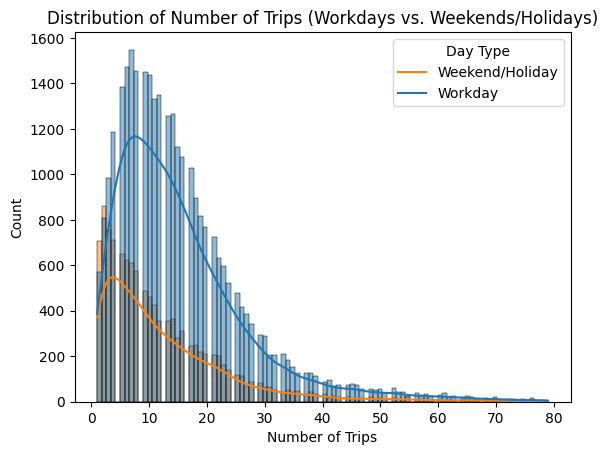

In [20]:
import seaborn as sns
hist_data = aggregated[aggregated['number_of_trips'] < 80]
hist_data = hist_data[hist_data['utilization_percentage'] <= 100]
hist_data = hist_data[hist_data['total_travel_distance'] <= 1200]
sns.histplot(data=hist_data, x='number_of_trips', hue='day_type', kde=True)
plt.title('Distribution of Number of Trips (Workdays vs. Weekends/Holidays)')
plt.xlabel('Number of Trips')
plt.legend(title='Day Type', labels=[ 'Weekend/Holiday', 'Workday'])
plt.show()

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\App

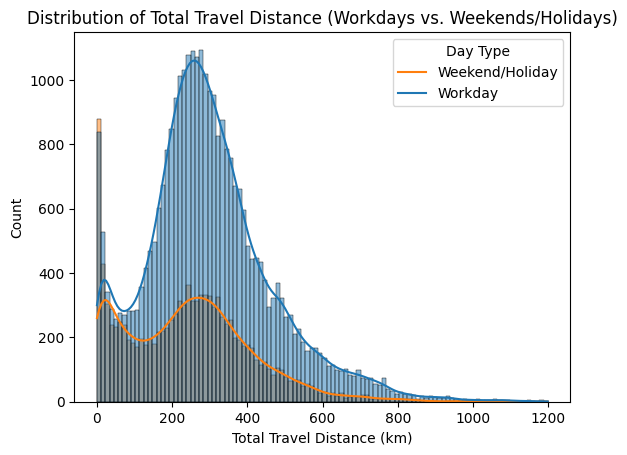

In [21]:
sns.histplot(data=hist_data, x='total_travel_distance', hue='day_type', kde=True)
plt.title('Distribution of Total Travel Distance (Workdays vs. Weekends/Holidays)')
plt.xlabel('Total Travel Distance (km)')
plt.ylabel('Count')
plt.legend(title='Day Type', labels=[ 'Weekend/Holiday', 'Workday'])
plt.show()

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nepim\App

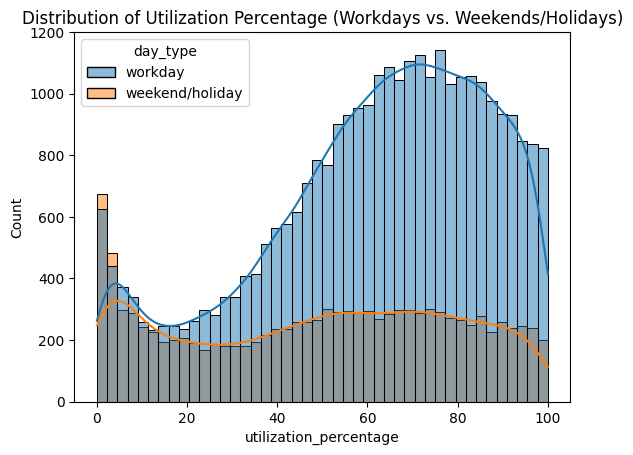

In [22]:
sns.histplot(data=hist_data, x='utilization_percentage', hue='day_type', kde=True)
plt.title('Distribution of Utilization Percentage (Workdays vs. Weekends/Holidays)')
plt.show()

In [23]:
avg_utilization = hist_data.groupby(['vehicle_id', 'day_type'])['utilization_percentage'].mean().unstack()

avg_utilization['difference'] = abs(avg_utilization['workday'] - avg_utilization['weekend/holiday'])

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


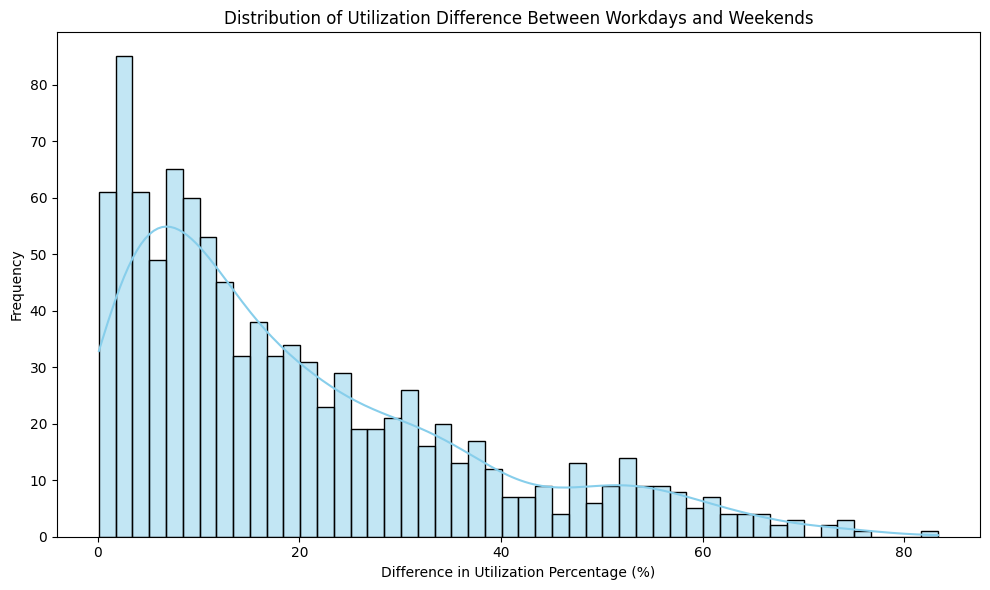

In [24]:

plt.figure(figsize=(10, 6))
sns.histplot(avg_utilization['difference'], bins=50, kde=True, color='skyblue')

plt.title('Distribution of Utilization Difference Between Workdays and Weekends')
plt.xlabel('Difference in Utilization Percentage (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

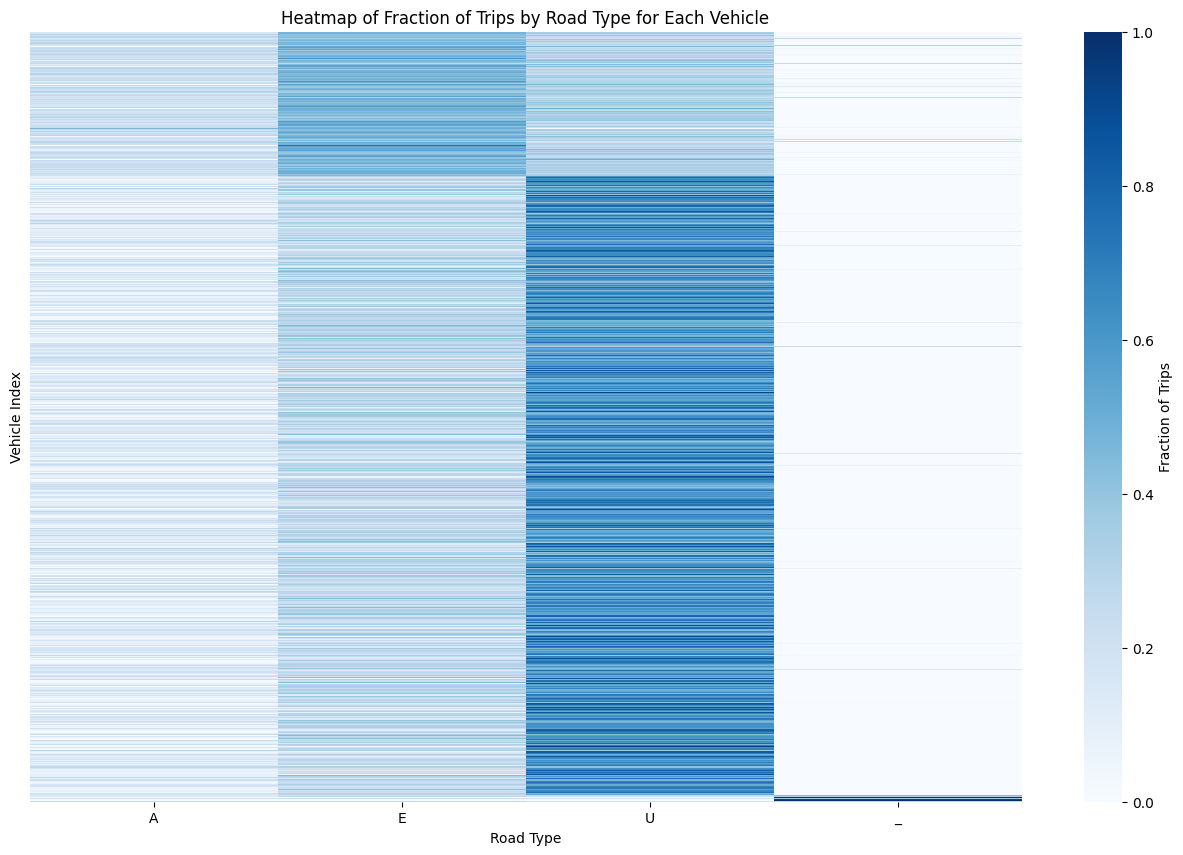

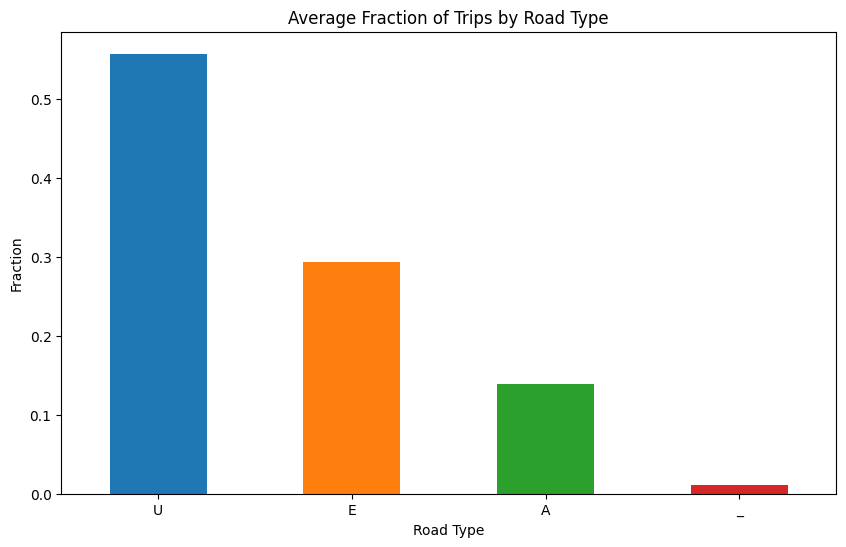

In [25]:

import seaborn as sns
vehicles = data[data["vehicle_id"].isin(data["vehicle_id"].unique())] #[:1000]
vehicles = vehicles[vehicles["vehicle_id"] != 539]

road_type_counts = vehicles.groupby(["vehicle_id", "road"]).size().unstack(fill_value=0)
road_type_counts = road_type_counts[(road_type_counts.sum(axis=1) > 0)]
road_type_fractions = road_type_counts.div(road_type_counts.sum(axis=1), axis=0)

road_type_fractions['Dominant_Road'] = road_type_fractions.idxmax(axis=1)
road_type_fractions = road_type_fractions.sort_values(by='Dominant_Road').drop(columns='Dominant_Road')

plt.figure(figsize=(16, 10))
sns.heatmap(
    road_type_fractions,
    cmap="Blues",
    cbar_kws={'label': 'Fraction of Trips'},
    xticklabels=True,
    yticklabels=False
)

plt.title("Heatmap of Fraction of Trips by Road Type for Each Vehicle")
plt.xlabel("Road Type")
plt.ylabel("Vehicle Index")
plt.show()


road_type_averages = road_type_fractions.mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
road_type_averages.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title("Average Fraction of Trips by Road Type")
plt.ylabel("Fraction")
plt.xlabel("Road Type")
plt.xticks(rotation=0)
plt.show()


C:\Users\nepim\AppData\Local\Temp\ipykernel_9188\3333024298.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(road_type_fractions[road_type], label=f"Road {road_type}", shade=True, color=color)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nepim\AppData\Local\Temp\ipykernel_9188\3333024298.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(road_type_fractions[road_type], label=f"Road {road_type}", shade=True, color=color)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-

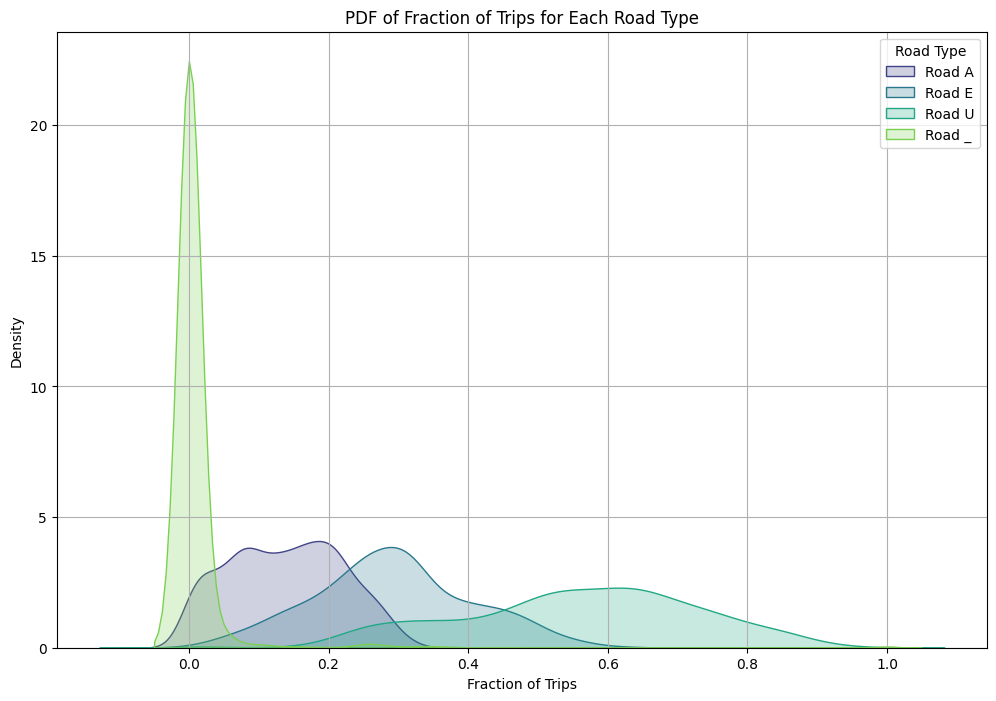

In [26]:
road_type_fractions = road_type_counts.div(road_type_counts.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("viridis", len(road_type_fractions.columns))

for road_type, color in zip(road_type_fractions.columns, colors):
    sns.kdeplot(road_type_fractions[road_type], label=f"Road {road_type}", shade=True, color=color)

plt.xlabel("Fraction of Trips")
plt.ylabel("Density")
plt.title("PDF of Fraction of Trips for Each Road Type")
plt.legend(title="Road Type")
plt.grid(True)
plt.show()

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

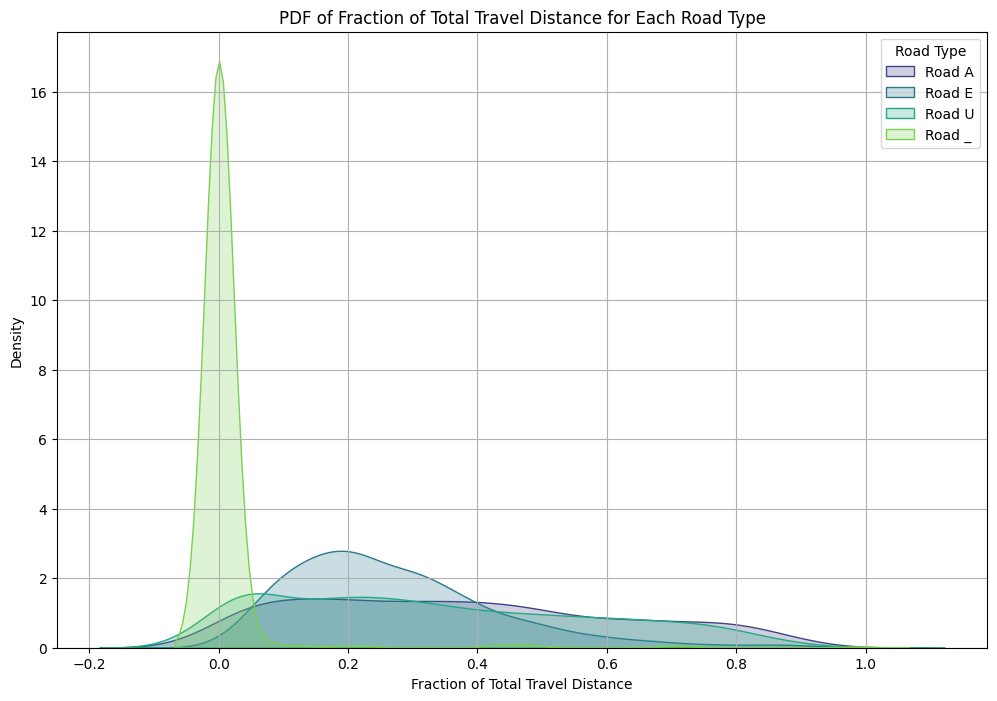

In [27]:
road_type_distance = vehicles.groupby(["vehicle_id", "road"])["total_distance"].sum().unstack(fill_value=0)

road_type_distance_fractions = road_type_distance.div(road_type_distance.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("viridis", len(road_type_distance_fractions.columns))
for road_type, color in zip(road_type_distance_fractions.columns, colors):
    sns.kdeplot(road_type_distance_fractions[road_type], label=f"Road {road_type}", fill=True, color=color)

plt.xlabel("Fraction of Total Travel Distance")
plt.ylabel("Density")
plt.title("PDF of Fraction of Total Travel Distance for Each Road Type")
plt.legend(title="Road Type")
plt.grid(True)
plt.show()

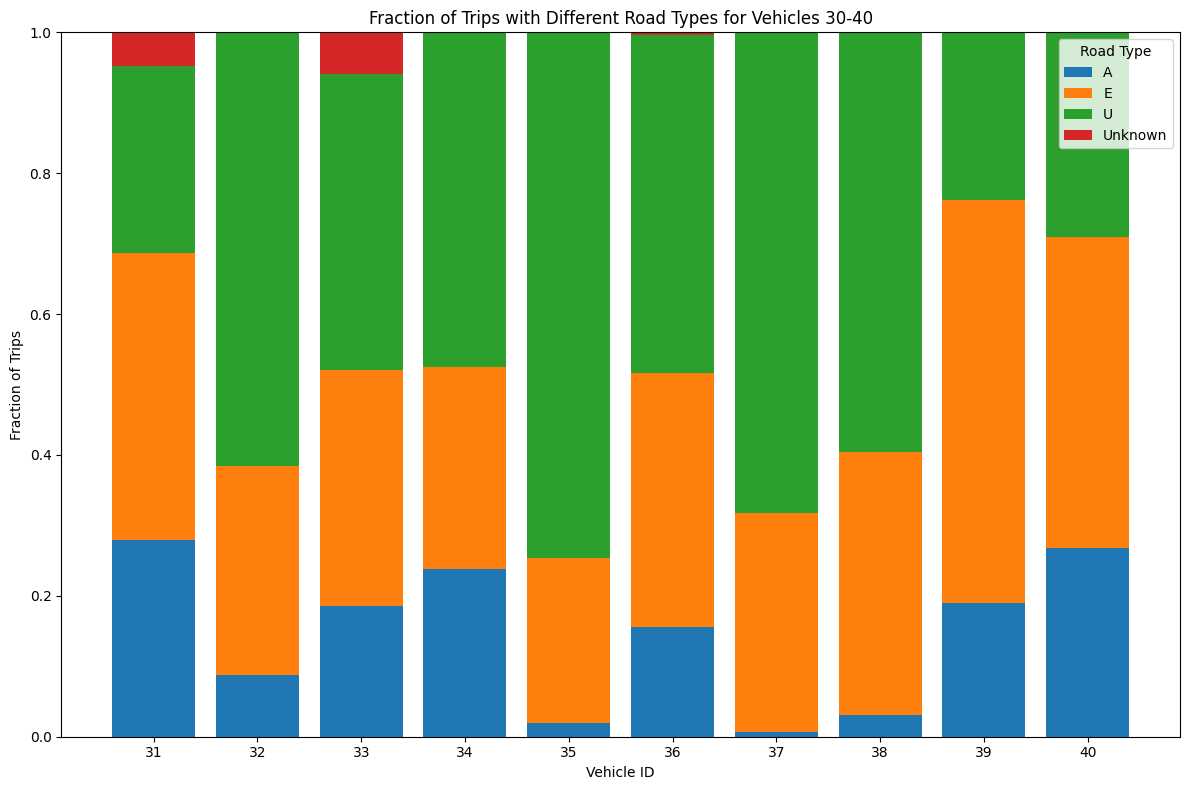

In [28]:
road_type_counts = vehicles.groupby(["vehicle_id", "road"]).size().unstack(fill_value=0)
road_type_counts = road_type_counts[30:40]

fig, ax = plt.subplots(figsize=(12, 8))

road_types = road_type_counts.columns
bottom = np.zeros(len(road_type_counts))

for road_type in road_types:
    if road_type == "_":
        label = "Unknown"
    else:
        label = road_type
    ax.bar(road_type_counts.index, road_type_counts[road_type] / road_type_counts.sum(axis=1), bottom=bottom, label=label)
    bottom += road_type_counts[road_type] / road_type_counts.sum(axis=1)

ax.set_title("Fraction of Trips with Different Road Types for Vehicles 30-40")
ax.set_ylabel("Fraction of Trips")
ax.set_xlabel("Vehicle ID")
ax.set_xticks(road_type_counts.index)
ax.legend(title="Road Type")
plt.tight_layout()
plt.show()

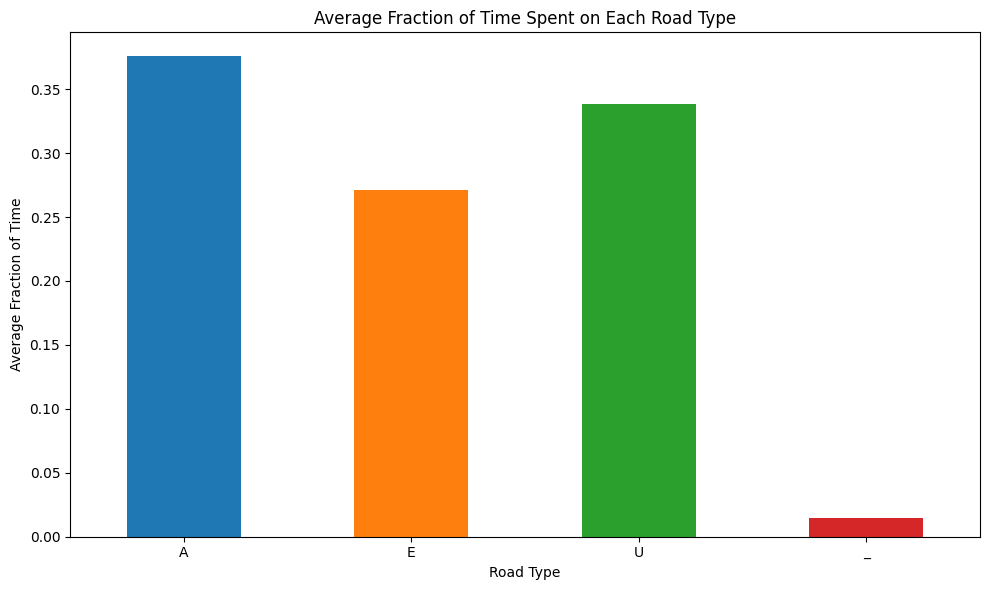

In [29]:
average_time_fractions = road_type_distance_fractions.mean()

plt.figure(figsize=(10, 6))
average_time_fractions.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title("Average Fraction of Time Spent on Each Road Type")
plt.ylabel("Average Fraction of Time")
plt.xlabel("Road Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
from sklearn.cluster import KMeans

# Example: cluster vehicles based on average # of trips/day, avg distance/day, fraction of trips on road 'A', etc.
vehicle_agg = (
    data.groupby("vehicle_id")
    .agg(
        avg_trips_per_day=("trip_id", lambda x: x.nunique() / ( (data["date"].max() - data["date"].min()).days + 1 )),
        avg_distance_per_day=("total_distance", lambda x: x.sum()   / ( (data["date"].max() - data["date"].min()).days + 1 )),
        fraction_road_A=("road", lambda x: np.mean(x == "A")),
        fraction_road_U=("road", lambda x: np.mean(x == "U")),
        fraction_road_E=("road", lambda x: np.mean(x == "E")),
    )
)

# K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
vehicle_agg["cluster"] = kmeans.fit_predict(vehicle_agg)

print(vehicle_agg.head(10))


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


            avg_trips_per_day  avg_distance_per_day  fraction_road_A  \
vehicle_id                                                             
1                    1.055670             54.675518         0.173256   
2                    0.585567             69.839629         0.256781   
3                    0.777320             72.234994         0.231190   
4                    0.981443             30.013979         0.075472   
5                    0.595876             71.547485         0.208413   
6                    1.952577             56.204386         0.123804   
7                    2.820619             29.781278         0.137626   
8                    0.785567             36.102412         0.051237   
9                    1.082474             34.237505         0.167832   
10                   1.672165             29.729938         0.096261   

            fraction_road_U  fraction_road_E  cluster  
vehicle_id                                             
1                  0.35

c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 2: Inertia = 53300.40, Silhouette Score = 0.6863


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 3: Inertia = 29098.10, Silhouette Score = 0.6669


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 4: Inertia = 19967.61, Silhouette Score = 0.5745


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 5: Inertia = 14630.24, Silhouette Score = 0.5478


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 6: Inertia = 11671.14, Silhouette Score = 0.5404


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 7: Inertia = 9623.30, Silhouette Score = 0.5343
k = 8: Inertia = 7912.40, Silhouette Score = 0.4792


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 9: Inertia = 6476.01, Silhouette Score = 0.5402
k = 10: Inertia = 5118.85, Silhouette Score = 0.4913


c:\Users\nepim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


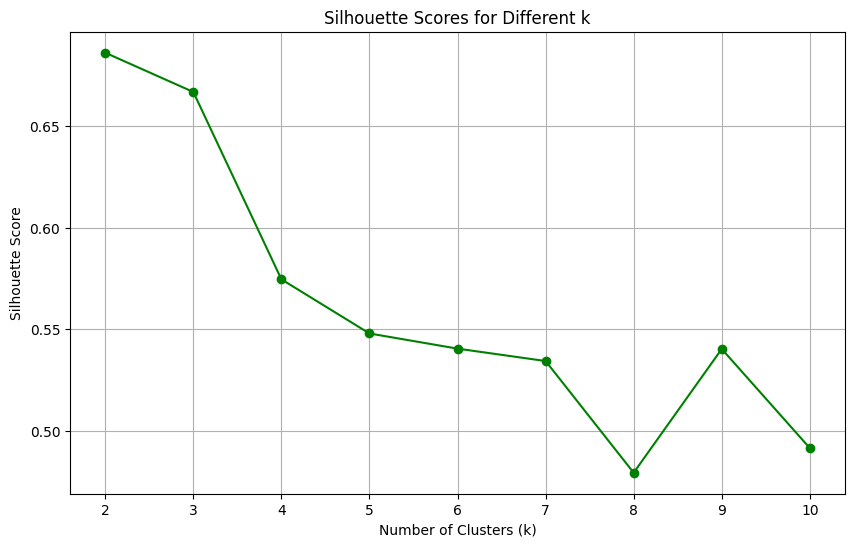

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


def evaluate_kmeans_clustering(data, k_range=(2, 10), random_state=42):
    inertia_values = []  
    silhouette_scores = []  

    for k in range(k_range[0], k_range[1] + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(data)
        
        
        inertia_values.append(kmeans.inertia_)
        
        
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
        print(f"k = {k}: Inertia = {kmeans.inertia_:.2f}, Silhouette Score = {score:.4f}")

    return inertia_values, silhouette_scores


k_range = (2, 10)  # Evaluate for k from 2 to 10
data_for_clustering = vehicle_agg.drop(columns=["cluster"])  
inertia_values, silhouette_scores = evaluate_kmeans_clustering(data_for_clustering, k_range)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(k_range[0], k_range[1] + 1), silhouette_scores, marker='o', linestyle='-', color='green')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.grid(True)
plt.show()


In [32]:
cluster_names = {
    0: "Urban Short Trips",
    1: "Highway Long Distances",
    2: "Frequent Commuters"
}
print("Cluster centers:")
print(kmeans.cluster_centers_)
cluster_profiles = vehicle_agg.groupby("cluster").mean()
print(cluster_profiles)

Cluster centers:
[[ 1.91624666 34.19045633  0.10672655  0.63981633  0.24962052]
 [ 1.01077048 74.63873117  0.21973982  0.35081449  0.39465651]
 [ 1.41251359 53.82338527  0.19102547  0.42058809  0.36887921]]
         avg_trips_per_day  avg_distance_per_day  fraction_road_A  \
cluster                                                             
0                 1.916247             34.190456         0.106727   
1                 1.010770             74.638731         0.219740   
2                 1.412514             53.823385         0.191025   

         fraction_road_U  fraction_road_E  
cluster                                    
0               0.639816         0.249621  
1               0.350814         0.394657  
2               0.420588         0.368879  


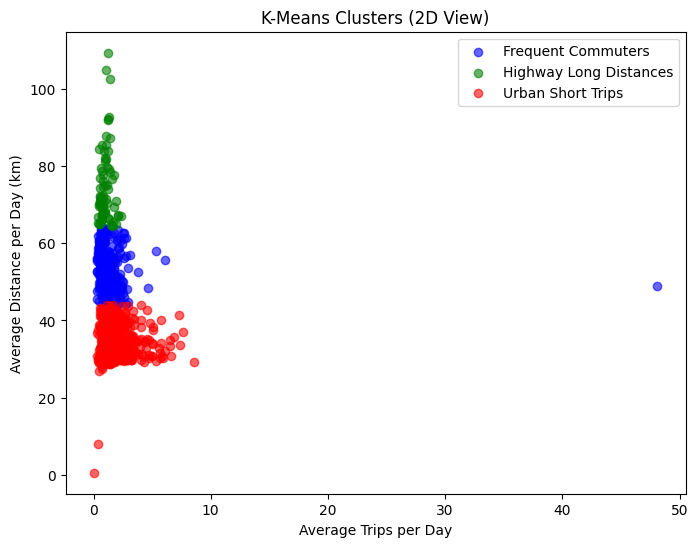

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
colors = {0: "red", 1: "green", 2: "blue"}  

for cluster_id in vehicle_agg["cluster"].unique():
    subset = vehicle_agg[vehicle_agg["cluster"] == cluster_id]
    ax.scatter(
        subset["avg_trips_per_day"],
        subset["avg_distance_per_day"],
        c=colors[cluster_id],
        label=cluster_names[cluster_id],
        alpha=0.6
    )

ax.set_xlabel("Average Trips per Day")
ax.set_ylabel("Average Distance per Day (km)")
ax.set_title("K-Means Clusters (2D View)")
ax.legend()
plt.show()

# Task 2

1. Tesla model 3 range: 420km
2. BMW iX xDrive40 range: 360km
3. Citroen e-C3  range: 260km



Evaluation Metrics
1. Percentage of Feasible Trips 
2. Energy Consumption per 100 km
3. Charging time

In [34]:
import json

cars = {
  "cars": {
    "Tesla Model 3": {
      "cost": 40990, #EUR Germany
      "range_km": 420,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 137, #Wh/km
        "charging_time": 6
      },
      "performance": {
        "acceleration_0_100_kmh": "6.1 sec",
        "top_speed_kmh": 201,
        "total_power_kw": 208,
        "total_torque_nm": 420,
        "drive": "Rear"
      },
      "battery": {
        "nominal_capacity_kwh": 60.0,
        "useable_capacity_kwh": 57.5,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 11,
          "charge_time_h": "6h15m",
          "charge_speed_kmh": 68
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 170,
          "charge_power_10_80_kw_dc": 108,
          "charge_time_min": 24,
          "charge_speed_kmh": 730
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 149,
        "highway_cold_weather_wh_km": 189,
        "combined_cold_weather_wh_km": 167,
        "city_mild_weather_wh_km": 93,
        "highway_mild_weather_wh_km": 142,
        "combined_mild_weather_wh_km": 116
      }
    },
    "BMW iX xDrive40": {
      "cost": 77300, #EUR Germany
      "range_km": 360,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 200, #Wh/km
        "charging_time": 8
      },
      "performance": {
        "acceleration_0_100_kmh": "6.1 sec",
        "top_speed_kmh": 200,
        "total_power_kw": 240,
        "total_torque_nm": 630,
        "drive": "All-Wheel Drive"
      },
      "battery": {
        "nominal_capacity_kwh": 76.6,
        "useable_capacity_kwh": 71,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 11,
          "charge_time_h": "8h",
          "charge_speed_kmh": 45
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 150,
          "charge_power_10_80_kw_dc": 110,
          "charge_time_min": 31,
          "charge_speed_kmh": 580
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 180,
        "highway_cold_weather_wh_km": 220,
        "combined_cold_weather_wh_km": 200,
        "city_mild_weather_wh_km": 140,
        "highway_mild_weather_wh_km": 180,
        "combined_mild_weather_wh_km": 160
      }
    },
    "Citroen e-C3": {
      "cost": 23300, #EUR Germany
      "range_km": 260,
      "evaluation_metrics": {
        "energy_consumption_per_100_km": 150, #Wh/km
        "charging_time": 7
      },
      "performance": {
        "acceleration_0_100_kmh": "9.7 sec",
        "top_speed_kmh": 150,
        "total_power_kw": 100,
        "total_torque_nm": 260,
        "drive": "Front"
      },
      "battery": {
        "nominal_capacity_kwh": 50,
        "useable_capacity_kwh": 45,
        "battery_type": "Lithium-ion"
      },
      "charging": {
        "home_destination": {
          "charge_port": "Type 2",
          "port_location": "Left Side - Rear",
          "charge_power_kw_ac": 7.4,
          "charge_time_h": "7h",
          "charge_speed_kmh": 37
        },
        "fast_charging": {
          "charge_port": "CCS",
          "port_location": "Left Side - Rear",
          "charge_power_max_kw_dc": 100,
          "charge_power_10_80_kw_dc": 75,
          "charge_time_min": 30,
          "charge_speed_kmh": 520
        }
      },
      "consumption": {
        "city_cold_weather_wh_km": 160,
        "highway_cold_weather_wh_km": 200,
        "combined_cold_weather_wh_km": 180,
        "city_mild_weather_wh_km": 120,
        "highway_mild_weather_wh_km": 160,
        "combined_mild_weather_wh_km": 140
      }
    }
  }
}



task 3

+-------------------+       +-------------------+       +-------------------+
| Define EVs & Trips| ----> | Replicate Trips   | ----> | Generate Report   |
+-------------------+       +-------------------+       +-------------------+
                               |
                               v
                        +-------------------+
                        | Simulate Consumption |
                        +-------------------+

In [35]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])

data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0
weather = "mild" #mild or cold
charging_type = "home_destination" #fast_charging or home_destination
vehicle_data = data.groupby("vehicle_id")
price_fast_charging = 0.5 #EUR per kWh
price_home_charging = 0.15 #EUR per kWh

results_list = []  # Initialize results_list outside the loop for each car model

for car, specs in cars["cars"].items():
    print(f"Simulating trips for {car}...")
    total_trips = 0
    feasible_trips = 0
    non_feasible = 0
    energy_consumed_100km = 0
    charge = 0
    kwh_after_trip = []
    charging_time = []
    energy_consumed = []
    distance_trips = []
    distance_vehicles = []
    energy_vehicles = []
    battery_capacity = specs["battery"]["useable_capacity_kwh"]   #  kWh 
    consumption_per_100_km = specs["evaluation_metrics"]["energy_consumption_per_100_km"]
    last_stop = ""

    for vehicle_id, trips in vehicle_data:
        remaining_kwh = battery_capacity
        total_charge_time = 0
        total_charging_events = 0
        distance_vehicle = []
        energy_vehicle = []
        
        for _, trip in trips.iterrows():
            trip_duration_hours = trip["trip_duration"] / 60.0  
            total_trips += 1
            distance_km = trip["total_distance"]
            if last_stop != "":
                time_since_last_stop = (trip["start_time"] - last_stop).total_seconds()/60 #minutes 
                if time_since_last_stop > 20:
                    
                    if charging_type == "fast_charging":
                        charged_power = specs["charging"][charging_type]["charge_power_10_80_kw_dc"] * time_since_last_stop / 60 #max or not?
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time= time_since_last_stop/60
                        else:
                            charge_time = (battery_capacity - remaining_kwh)/specs["charging"][charging_type]["charge_power_10_80_kw_dc"]
                            remaining_kwh = battery_capacity
                    else:
                        charged_power = specs["charging"]["home_destination"]["charge_power_kw_ac"] * time_since_last_stop / 60
                        if remaining_kwh + charged_power <= battery_capacity:
                            remaining_kwh = remaining_kwh + charged_power
                            charge_time = time_since_last_stop/60
                        else:
                            charge_time = (battery_capacity - remaining_kwh)/specs["charging"]["home_destination"]["charge_power_kw_ac"]
                            remaining_kwh = battery_capacity
                    charging_time.append(charge_time)
                    total_charge_time += charge_time
                    total_charging_events += 1
                    
            if weather == "cold":
                if trip.road == "U":
                    consumption = specs["consumption"]["city_cold_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_cold_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_cold_weather_wh_km"]
            else:
                if trip.road == "U":
                    consumption = specs["consumption"]["city_mild_weather_wh_km"]
                elif trip.road == "A":
                    consumption = specs["consumption"]["highway_mild_weather_wh_km"]
                else:
                    consumption = specs["consumption"]["combined_mild_weather_wh_km"]

            energy_needed = (distance_km * consumption) / 1000  #  Wh in kWh
            if energy_needed > remaining_kwh:
                non_feasible = non_feasible + 1
                remaining_kwh = 0
            else:
                remaining_kwh = remaining_kwh - energy_needed
                feasible_trips = feasible_trips + 1
                energy_consumed.append(energy_needed)
                energy_vehicle.append(energy_needed)
                distance_trips.append(distance_km)
                distance_vehicle.append(distance_km)

            kwh_after_trip.append(remaining_kwh)
            last_stop = trip.stop_time
        distance_vehicles.append(sum(distance_vehicle))
        energy_vehicles.append(sum(energy_vehicle))


   
        
        feasible_percentage = (feasible_trips / total_trips) * 100 if total_trips > 0 else 0
        print(feasible_percentage)
        charge_time = np.mean(total_charge_time) 
        hours, minutes = divmod(charge_time, 60)  # hours and minutes
        avg_kwh = np.mean(kwh_after_trip)
        energy_consumed_100km = np.mean(energy_consumed)/np.mean(distance_trips)*1000
        results_list.append({
            "vehicle_id": vehicle_id,
            "car": car,
            "total_trips": total_trips,
            "feasible_percentage": feasible_percentage,
            "average_charge_time": f"{int(hours)} hours and {int(minutes)} minutes",
            "Total Charging Events": total_charging_events,
            "average_soc_after_trip": avg_kwh,
            "soc_percentage": avg_kwh / battery_capacity * 100,
            "energy_consumption_per_100km": energy_consumed_100km,
            "average_energy_cost": np.mean(energy_vehicles) * price_home_charging,
            "car_cost": specs['cost']
        
    })

results_df = pd.DataFrame(results_list)
print(results_df)

Simulating trips for Tesla Model 3...
90.69767441860465
83.36871903750884
75.74626865671642
81.6448993999294
80.42312276519667
87.04461328657706
90.25783767946088
91.00378787878788
91.7939393939394
92.8789313137688
94.08320223737108
94.63464891424948
92.25859125658725
92.7876990967386
93.42675799660654
93.15869631434663
93.82621534423362
93.38184886357644
92.89397689768977
93.24383695386868
93.28795613537531
93.57087879748268
93.72142103411889
93.62365913073208
93.88178783684768
94.05512730670405
94.35948581560284
94.5712457337884
94.26026200873362
94.61379784551914
94.38437953848636
94.59186484253053
94.29414218461355
94.26550758803594
94.56728084868789
93.94607843137254
94.19779187221047
94.40459110473458
94.14528639618138
93.90246904462988
93.9868424246838
93.79493181112517
93.94278519969225
93.68387156132118
93.1001996366165
93.07206456423526
93.29569812602135
93.35374489710905
93.53865467946382
93.30711804862469
93.28027422627608
93.26140377822148
93.35060612364543
93.063540794492

In [36]:
merged_df = results_df.merge(
    vehicle_agg[["cluster"]], 
    how="left",
    left_on="vehicle_id",
    right_index=True
)

merged_df.head(10)

,vehicle_id,car,total_trips,feasible_percentage,average_charge_time,Total Charging Events,average_soc_after_trip,soc_percentage,energy_consumption_per_100km,average_energy_cost,car_cost,cluster
0,1,Tesla Model 3,860,90.697674,4 hours and 39 minutes,240,33.926647,59.002864,130.078523,413.361047,40990,2
1,2,Tesla Model 3,1413,83.368719,4 hours and 33 minutes,220,29.958914,52.102459,130.564182,365.036264,40990,1
2,3,Tesla Model 3,2144,75.746269,3 hours and 53 minutes,199,24.684699,42.929911,129.451431,309.210012,40990,1
3,4,Tesla Model 3,2833,81.644899,2 hours and 15 minutes,233,30.998126,53.909784,123.485913,288.628899,40990,0
4,5,Tesla Model 3,3356,80.423123,4 hours and 29 minutes,203,30.863149,53.675042,124.467387,288.683668,40990,1
5,6,Tesla Model 3,5133,87.044613,4 hours and 42 minutes,353,35.897087,62.429716,121.975400,318.081154,40990,2
6,7,Tesla Model 3,6826,90.257838,2 hours and 15 minutes,214,39.302401,68.352003,119.697898,304.598291,40990,0
7,8,Tesla Model 3,7392,91.003788,2 hours and 51 minutes,226,39.938270,69.457860,118.291657,302.228217,40990,0
8,9,Tesla Model 3,8250,91.793939,3 hours and 2 minutes,285,40.469858,70.382361,118.938479,301.123993,40990,0
9,10,Tesla Model 3,9507,92.878931,2 hours and 26 minutes,204,40.884948,71.104257,118.492292,295.623060,40990,0


In [37]:
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return 0  
    hours, minutes = map(int, time_str.replace(" hours", "").replace(" minutes", "").split(" and "))
    return hours + minutes / 60

merged_df["avg_charging_time_hrs"] = merged_df["average_charge_time"].apply(convert_time_to_hours)


results_with_clusters = merged_df.groupby(["cluster", "car","vehicle_id"]).agg({
    "feasible_percentage": "mean",
    "avg_charging_time_hrs": "mean",
    "total_trips": "mean",
    "average_soc_after_trip": "mean",
    "energy_consumption_per_100km": "mean",
    "average_energy_cost": "mean",
    "car_cost": "mean",
    "Total Charging Events": "mean"
}).reset_index()

print(results_with_clusters)



      cluster              car  vehicle_id  feasible_percentage  \
0           0  BMW iX xDrive40           4            77.867984   
1           0  BMW iX xDrive40           7            88.221506   
2           0  BMW iX xDrive40           8            89.123377   
3           0  BMW iX xDrive40           9            90.012121   
4           0  BMW iX xDrive40          10            91.332702   
...       ...              ...         ...                  ...   
2992        2    Tesla Model 3         987            94.867908   
2993        2    Tesla Model 3         992            94.894112   
2994        2    Tesla Model 3         994            94.914646   
2995        2    Tesla Model 3         995            94.906980   
2996        2    Tesla Model 3         997            94.894095   

      avg_charging_time_hrs  total_trips  average_soc_after_trip  \
0                  3.250000       2833.0               35.494205   
1                  3.233333       6826.0               43.8

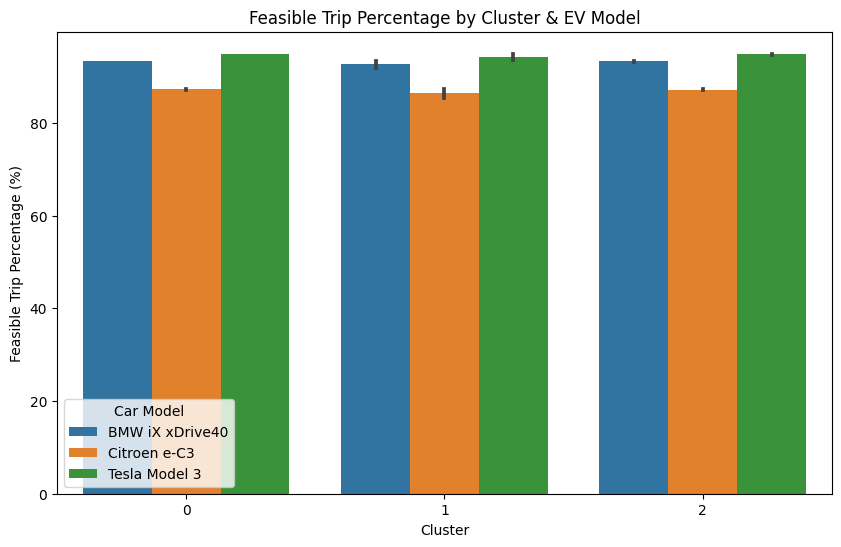

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_with_clusters, 
    x="cluster", 
    y="feasible_percentage", 
    hue="car"
)
plt.title("Feasible Trip Percentage by Cluster & EV Model")
plt.xlabel("Cluster")
plt.ylabel("Feasible Trip Percentage (%)")
plt.legend(title="Car Model")
plt.show()

In [39]:
def calculate_compatibility_score(results_df, cars, weights_perf=(0.4, 0.2, 0.2, 0.2), weights_cost=(0.7, 0.3), alpha=0.6):
    """
    Adjusted compatibility score function.
    """
    results_df["feasible_percentage"] = results_df["feasible_percentage"] / 100  
    results_df["Normalized Charge Time"] = 1 - (results_df["avg_charging_time_hrs"] - results_df["avg_charging_time_hrs"].min()) / (results_df["avg_charging_time_hrs"].max() - results_df["avg_charging_time_hrs"].min())
    results_df["Normalized Energy Consumption"] = 1 - (results_df["energy_consumption_per_100km"] - results_df["energy_consumption_per_100km"].min()) / (results_df["energy_consumption_per_100km"].max() - results_df["energy_consumption_per_100km"].min())
    results_df["Normalized Charging Events"] = 1 - (results_df["Total Charging Events"] / results_df["Total Charging Events"].max())

    results_df["Performance Score"] = (
        weights_perf[0] * results_df["feasible_percentage"] +
        weights_perf[1] * results_df["Normalized Charge Time"] +
        weights_perf[2] * results_df["Normalized Energy Consumption"] +
        weights_perf[3] * results_df["Normalized Charging Events"]
    )

    # Cost normalization
    results_df["Normalized Energy Cost"] = 1 - (results_df["average_energy_cost"] - results_df["average_energy_cost"].min()) / (results_df["average_energy_cost"].max() - results_df["average_energy_cost"].min())
    results_df["Normalized Purchase Cost"] = 1 - (results_df["car_cost"] - results_df["car_cost"].min()) / (results_df["car_cost"].max() - results_df["car_cost"].min())

    results_df["Cost Score"] = (
        weights_cost[0] * results_df["Normalized Energy Cost"] +
        weights_cost[1] * results_df["Normalized Purchase Cost"]
    )

    results_df["Compatibility Score"] = (
        alpha * results_df["Performance Score"] +
        (1 - alpha) * results_df["Cost Score"]
    )

    sorted_results = results_df.sort_values(by=["vehicle_id", "Compatibility Score"], ascending=[True, False])
    
    return sorted_results


In [53]:
# Calculate compatibility scores
sorted_results = calculate_compatibility_score(results_with_clusters, cars, alpha=0.7)

sorted_results.groupby("vehicle_id").head(1)


,cluster,car,vehicle_id,feasible_percentage,avg_charging_time_hrs,total_trips,average_soc_after_trip,energy_consumption_per_100km,average_energy_cost,car_cost,Total Charging Events,Normalized Charge Time,Normalized Energy Consumption,Normalized Charging Events,Performance Score,Normalized Energy Cost,Normalized Purchase Cost,Cost Score,Compatibility Score
2447,2,Citroen e-C3,1,0.007384,6.150000,860.0,20.113231,148.811365,289.476618,23300.0,240.0,0.336347,0.399731,0.622642,0.274697,0.732580,1.000000,0.812806,0.436130
2020,1,Citroen e-C3,2,0.006766,5.466667,1413.0,17.814769,148.380593,240.814269,23300.0,220.0,0.410488,0.407577,0.654088,0.297137,0.889637,1.000000,0.922746,0.484820
2021,1,Citroen e-C3,3,0.006007,4.383333,2144.0,14.545609,147.254741,206.619547,23300.0,199.0,0.528029,0.428083,0.687107,0.331047,1.000000,1.000000,1.000000,0.531733
1296,0,Tesla Model 3,4,0.008164,2.250000,2833.0,30.998126,123.485913,288.628899,40990.0,233.0,0.759494,0.861003,0.633648,0.454095,0.735316,0.672407,0.716443,0.532799
2022,1,Citroen e-C3,5,0.006862,5.366667,3356.0,19.618108,142.205326,218.088058,23300.0,203.0,0.421338,0.520052,0.680818,0.327186,0.962986,1.000000,0.974090,0.521257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,0,Tesla Model 3,996,0.009490,2.716667,1239076.0,41.400336,117.545544,297.193320,40990.0,167.0,0.708861,0.969199,0.737421,0.486892,0.707674,0.672407,0.697094,0.549953
2996,2,Tesla Model 3,997,0.009489,3.166667,1239643.0,41.393445,117.554709,297.153364,40990.0,195.0,0.660036,0.969032,0.693396,0.468289,0.707803,0.672407,0.697184,0.536957
1941,0,Tesla Model 3,998,0.009490,3.416667,1240762.0,41.386599,117.559054,297.180493,40990.0,186.0,0.632911,0.968953,0.707547,0.465678,0.707716,0.672407,0.697123,0.535112
1942,0,Tesla Model 3,999,0.009490,2.400000,1242783.0,41.401069,117.545322,297.124618,40990.0,266.0,0.743219,0.969203,0.581761,0.462633,0.707896,0.672407,0.697249,0.533018


C:\Users\nepim\AppData\Local\Temp\ipykernel_9188\3392758573.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_ev_df = sorted_results.groupby("vehicle_id").apply(lambda x: x.nlargest(1, "Compatibility Score")).reset_index(drop=True)


     vehicle_id  Compatibility Score            car  cluster
0             1             0.645119  Tesla Model 3        2
1             2             0.672366   Citroen e-C3        1
2             3             0.698260   Citroen e-C3        1
3             4             0.759119  Tesla Model 3        0
4             5             0.725838  Tesla Model 3        1
..          ...                  ...            ...      ...
994         996             0.813027  Tesla Model 3        0
995         997             0.800004  Tesla Model 3        2
996         998             0.798162  Tesla Model 3        0
997         999             0.796091  Tesla Model 3        0
998        1000             0.822700  Tesla Model 3        0

[999 rows x 4 columns]


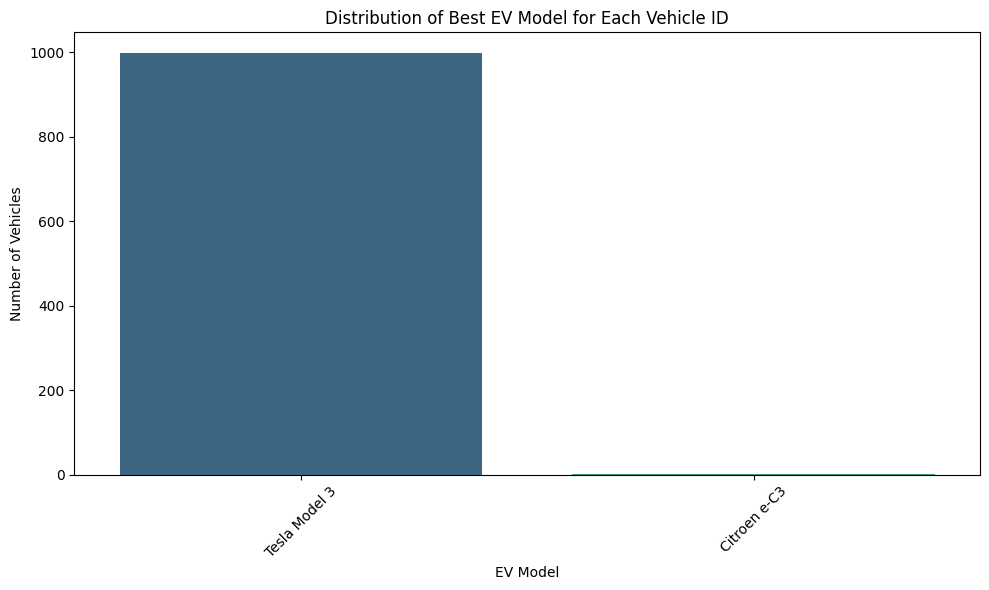

In [41]:

def best_ev_model_per_vehicle(sorted_results):
    best_ev_df = sorted_results.groupby("vehicle_id").apply(lambda x: x.nlargest(1, "Compatibility Score")).reset_index(drop=True)
    best_ev_df = best_ev_df[["vehicle_id", "Compatibility Score", "car", "cluster"]]
    return best_ev_df

# Plot the distribution of the best EV models
def plot_best_ev_models(best_ev_df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    sns.countplot(data=best_ev_df, x="car", order=best_ev_df["car"].value_counts().index, palette="viridis")
    plt.title("Distribution of Best EV Model for Each Vehicle ID")
    plt.xlabel("EV Model")
    plt.ylabel("Number of Vehicles")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Apply the functions
best_ev_df = best_ev_model_per_vehicle(sorted_results)
print(best_ev_df)
plot_best_ev_models(best_ev_df)


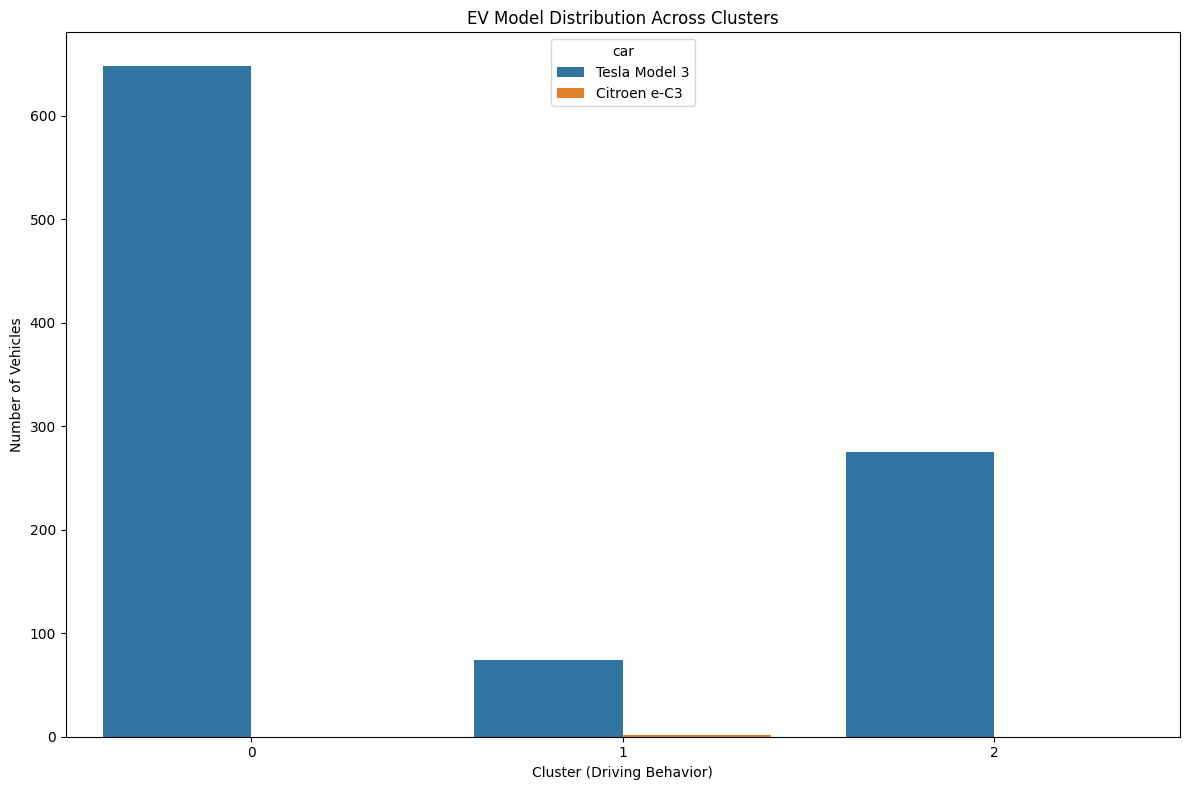

In [42]:

cluster_ev_summary = best_ev_df.groupby(["cluster", "car"]).size().reset_index(name="Count")


def plot_cluster_ev_summary(cluster_ev_summary):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 8))
    sns.barplot(data=cluster_ev_summary, x="cluster", y="Count", hue="car", palette="tab10")
    plt.title("EV Model Distribution Across Clusters")
    plt.xlabel("Cluster (Driving Behavior)")
    plt.ylabel("Number of Vehicles")
    plt.tight_layout()
    plt.show()

plot_cluster_ev_summary(cluster_ev_summary)


In [43]:

avg_compatibility_per_cluster = sorted_results.groupby(["cluster", "car"]).agg(
    avg_compatibility_score=("Compatibility Score", "mean")
).reset_index()


print(avg_compatibility_per_cluster)


   cluster              car  avg_compatibility_score
0        0  BMW iX xDrive40                 0.551005
1        0     Citroen e-C3                 0.741024
2        0    Tesla Model 3                 0.801232
3        1  BMW iX xDrive40                 0.521127
4        1     Citroen e-C3                 0.723322
5        1    Tesla Model 3                 0.768797
6        2  BMW iX xDrive40                 0.532163
7        2     Citroen e-C3                 0.729473
8        2    Tesla Model 3                 0.782910


## Task 6

In [44]:
import random
import pandas as pd


def is_nighttime(dt, night_start=22, night_end=6):
    hour = dt.hour
    return (hour >= night_start) or (hour < night_end)

def simulate_all_ev_models_with_refined_policy_debug(vehicle_data, cars, min_parking_time=40):
    results = []  # Store results for each EV

    for car, specs in cars["cars"].items():
        print(f"Running simulation for {car}...\n{'-' * 60}")

        for vehicle_id, trips in vehicle_data:
            battery_capacity = specs["battery"]["useable_capacity_kwh"]  # in kWh
            price_home_charging = 0.15  
            price_fast_charging = 0.50  

            soc = battery_capacity  
            total_cost = 0  
            feasible_trips = 0
            unfeasible_trips = 0
            total_energy_consumed = 0  
            total_trip_distance = 0  
            total_charge_time = 0  
            charging_events = 0  
            soc_after_trips = []
            last_stop = None

            for trip_index, trip in trips.iterrows():
                trip_start = trip["start_time"]
                trip_stop = trip["stop_time"]
                distance_km = trip["total_distance"]
                parking_time_minutes = (trip_start - last_stop).total_seconds() / 60 if last_stop else 0

                # Charge if idle time is above the threshold
                if last_stop is not None and parking_time_minutes >= min_parking_time:
                    is_night = is_nighttime(last_stop)
                    if is_night:
                        charge_power = specs["charging"]["home_destination"]["charge_power_kw_ac"]
                        charge_cost = price_home_charging
                    else:
                        road_type = trip["road"]
                        charge_power = 0
                        if road_type == "A" and random.random() < 0.8:
                            charge_power = specs["charging"]["fast_charging"]["charge_power_max_kw_dc"]
                            charge_cost = price_fast_charging
                        elif road_type == "U" and random.random() < 0.5:
                            charge_power = specs["charging"]["fast_charging"]["charge_power_max_kw_dc"]
                            charge_cost = price_fast_charging
                        elif road_type == "E" and random.random() < 0.3:
                            charge_power = specs["charging"]["fast_charging"]["charge_power_max_kw_dc"]
                            charge_cost = price_fast_charging

                    hours_to_charge = parking_time_minutes / 60
                    energy_to_charge = charge_power * hours_to_charge

                    if soc + energy_to_charge > battery_capacity:
                        energy_to_charge = battery_capacity - soc

                    if energy_to_charge > 0:
                        soc += energy_to_charge
                        total_cost += energy_to_charge * charge_cost
                        total_charge_time += hours_to_charge
                        charging_events += 1  

                # Attempt the trip
                consumption_rate = specs["evaluation_metrics"]["energy_consumption_per_100_km"] / 1000  # kWh/km
                energy_needed = distance_km * consumption_rate

                if energy_needed > soc:
                    unfeasible_trips += 1
                    soc = 0  # Vehicle arrives with 0 SoC
                    total_energy_consumed += energy_needed
                else:
                    soc -= energy_needed
                    feasible_trips += 1
                    total_trip_distance += distance_km
                    total_energy_consumed += energy_needed

                soc_after_trips.append(soc)
                last_stop = trip_stop

            # Calculate final metrics 
            feasible_percentage = (feasible_trips / len(trips)) * 100 if len(trips) > 0 else 0
            num_days = trips["start_time"].dt.date.nunique()  # Count unique days
            avg_charge_time = total_charge_time / charging_events if charging_events > 0 else 0  
            avg_charge_time_per_day = total_charge_time / num_days if num_days > 0 else 0  
            hours_session, minutes_session = divmod(avg_charge_time * 60, 60)  
            hours_day, minutes_day = divmod(avg_charge_time_per_day * 60, 60)  
            avg_soc_after_trip = sum(soc_after_trips) / len(soc_after_trips) if len(soc_after_trips) > 0 else 0
            avg_energy_consumed_per_100km = (total_energy_consumed / total_trip_distance) * 1000 if total_trip_distance > 0 else 0

            results.append({
                "car": car,
                "vehicle_id": vehicle_id,
                "feasible_percentage": feasible_percentage,
                "avg_charging_time_hrs": f"{int(hours_session)}h {int(minutes_session)}m",
                "Average Charge Time per Day (hours:minutes)": f"{int(hours_day)}h {int(minutes_day)}m",
                "average_soc_after_trip": avg_soc_after_trip,
                "energy_consumption_per_100_km": avg_energy_consumed_per_100km,
                "average_energy_cost": total_cost,
                "Total Charging Events": charging_events,
                "car_cost": specs["cost"]
            })

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df



In [45]:
vehicle_data = data.groupby("vehicle_id")
results_df_t6 = simulate_all_ev_models_with_refined_policy_debug(vehicle_data, cars)

Running simulation for Tesla Model 3...
------------------------------------------------------------
Running simulation for BMW iX xDrive40...
------------------------------------------------------------
Running simulation for Citroen e-C3...
------------------------------------------------------------
                car  vehicle_id  feasible_percentage avg_charging_time_hrs  \
0     Tesla Model 3           1            74.069767                 7h 4m   
1     Tesla Model 3           2            71.247740                 5h 8m   
2     Tesla Model 3           3            48.426813                2h 38m   
3     Tesla Model 3           4            96.371553                5h 54m   
4     Tesla Model 3           5            62.523901                6h 22m   
...             ...         ...                  ...                   ...   
2992   Citroen e-C3         996            64.991334                 8h 4m   
2993   Citroen e-C3         997            51.499118                3h 5

In [46]:
merged_df_t6 = results_df_t6.merge(
    vehicle_agg[["cluster"]],  
    how="left",
    left_on="vehicle_id",
    right_index=True
)


merged_df_t6.head(10)


,car,vehicle_id,feasible_percentage,avg_charging_time_hrs,Average Charge Time per Day (hours:minutes),average_soc_after_trip,energy_consumption_per_100_km,average_energy_cost,Total Charging Events,car_cost,cluster
0,Tesla Model 3,1,74.069767,7h 4m,9h 48m,25.231308,205.429364,1268.941753,79,40990,2
1,Tesla Model 3,2,71.247740,5h 8m,11h 11m,24.274613,259.310238,1289.363486,109,40990,1
2,Tesla Model 3,3,48.426813,2h 38m,4h 33m,13.230940,445.429321,1051.501559,90,40990,1
3,Tesla Model 3,4,96.371553,5h 54m,10h 45m,42.760518,143.310606,692.246604,113,40990,0
4,Tesla Model 3,5,62.523901,6h 22m,10h 50m,21.670538,332.284839,1000.848636,90,40990,1
5,Tesla Model 3,6,94.597636,4h 13m,10h 34m,36.967754,148.259724,1327.941317,155,40990,2
6,Tesla Model 3,7,99.704666,5h 49m,8h 58m,40.607927,137.768202,859.028844,94,40990,0
7,Tesla Model 3,8,87.809187,5h 56m,8h 6m,32.752566,162.474341,986.767857,82,40990,0
8,Tesla Model 3,9,93.473193,5h 35m,12h 39m,40.772359,156.692767,756.034229,138,40990,0
9,Tesla Model 3,10,79.395386,10h 30m,12h 15m,26.362064,168.437590,738.951611,63,40990,0


In [47]:
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return 0  # Handle NaN values
    if isinstance(time_str, str):
        hours, minutes = map(int, time_str.replace("h", "").replace("m", "").split(" "))
        return hours + minutes / 60
    return time_str  


merged_df_t6["avg_charging_time_hrs"] = merged_df_t6["avg_charging_time_hrs"].apply(convert_time_to_hours)


results_with_clusters_t6 = merged_df_t6.groupby(["cluster", "car","vehicle_id"]).agg({
    "feasible_percentage": "mean",
    "avg_charging_time_hrs": "mean",
    "Total Charging Events": "mean",
    "average_soc_after_trip": "mean",
    "energy_consumption_per_100_km": "mean",
    "average_energy_cost": "mean",
    "car_cost": "mean",
}).reset_index()

print(results_with_clusters_t6)

      cluster              car  vehicle_id  feasible_percentage  \
0           0  BMW iX xDrive40           4            93.323657   
1           0  BMW iX xDrive40           7            91.553455   
2           0  BMW iX xDrive40           8            75.088339   
3           0  BMW iX xDrive40           9            93.822844   
4           0  BMW iX xDrive40          10            88.464598   
...       ...              ...         ...                  ...   
2992        2    Tesla Model 3         987            68.911917   
2993        2    Tesla Model 3         992            92.117264   
2994        2    Tesla Model 3         994            76.770857   
2995        2    Tesla Model 3         995            68.124118   
2996        2    Tesla Model 3         997            65.961199   

      avg_charging_time_hrs  Total Charging Events  average_soc_after_trip  \
0                  6.166667                  107.0               47.343756   
1                  5.783333            

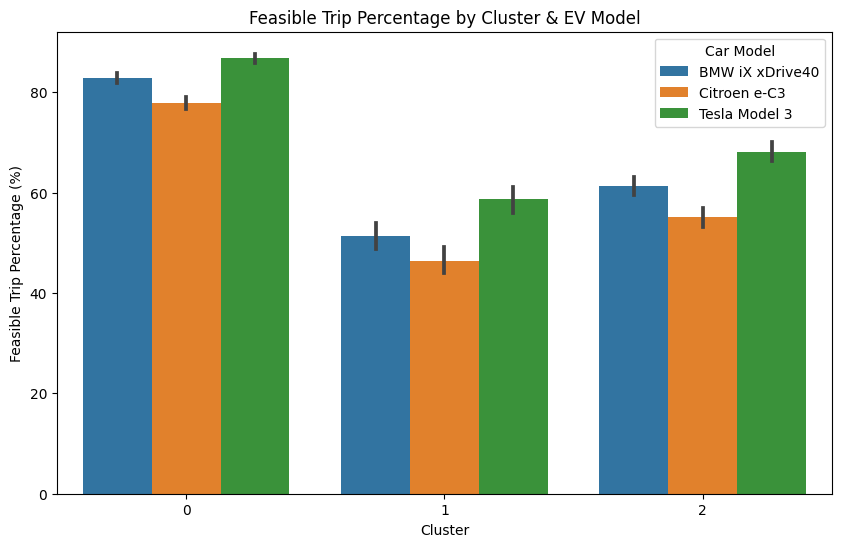

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_with_clusters_t6, 
    x="cluster", 
    y="feasible_percentage", 
    hue="car"
)
plt.title("Feasible Trip Percentage by Cluster & EV Model")
plt.xlabel("Cluster")
plt.ylabel("Feasible Trip Percentage (%)")
plt.legend(title="Car Model")
plt.show()

In [49]:
sorted_results_t6 = calculate_compatibility_score(results_with_clusters_t6.rename(columns={'energy_consumption_per_100_km': 'energy_consumption_per_100km'}), cars, alpha=0.7)

# Display top EV model per vehicle
sorted_results_t6.groupby("vehicle_id").head(1)

,cluster,car,vehicle_id,feasible_percentage,avg_charging_time_hrs,Total Charging Events,average_soc_after_trip,energy_consumption_per_100km,average_energy_cost,car_cost,Normalized Charge Time,Normalized Energy Consumption,Normalized Charging Events,Performance Score,Normalized Energy Cost,Normalized Purchase Cost,Cost Score,Compatibility Score
2722,2,Tesla Model 3,1,0.740698,7.066667,79.0,25.231308,205.429364,1268.941753,40990.0,0.984109,0.981677,0.677551,0.824947,0.480773,0.672407,0.538264,0.738942
2096,1,Tesla Model 3,2,0.712477,5.133333,109.0,24.274613,259.310238,1289.363486,40990.0,0.989712,0.967250,0.555102,0.787404,0.472396,0.672407,0.532399,0.710902
2021,1,Citroen e-C3,3,0.361149,2.000000,87.0,7.605413,750.926109,801.115422,23300.0,0.998793,0.835614,0.644898,0.640321,0.672690,1.000000,0.770883,0.679489
648,0,Citroen e-C3,4,0.847605,6.233333,105.0,27.152106,183.206470,629.168025,23300.0,0.986524,0.987628,0.571429,0.848158,0.743228,1.000000,0.820259,0.839789
2098,1,Tesla Model 3,5,0.625239,6.366667,90.0,21.670538,332.284839,1000.848636,40990.0,0.986138,0.947710,0.632653,0.763396,0.590753,0.672407,0.615249,0.718952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,0,Citroen e-C3,996,0.649913,8.066667,48.0,16.351672,430.232564,449.709392,23300.0,0.981211,0.921484,0.804082,0.801321,0.816847,1.000000,0.871793,0.822462
2996,2,Tesla Model 3,997,0.659612,3.550000,73.0,23.543195,252.485093,721.128039,40990.0,0.994301,0.969078,0.702041,0.796929,0.705503,0.672407,0.695574,0.766522
1941,0,Tesla Model 3,998,0.862377,6.633333,106.0,27.740470,198.498648,904.982831,40990.0,0.985365,0.983533,0.567347,0.852200,0.630080,0.672407,0.642778,0.789373
1942,0,Tesla Model 3,999,0.926769,4.583333,90.0,36.513366,147.847852,906.121439,40990.0,0.991306,0.997095,0.632653,0.894918,0.629613,0.672407,0.642451,0.819178


C:\Users\nepim\AppData\Local\Temp\ipykernel_9188\3392758573.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_ev_df = sorted_results.groupby("vehicle_id").apply(lambda x: x.nlargest(1, "Compatibility Score")).reset_index(drop=True)


     vehicle_id  Compatibility Score            car  cluster
0             1             0.738942  Tesla Model 3        2
1             2             0.710902  Tesla Model 3        1
2             3             0.679489   Citroen e-C3        1
3             4             0.839789   Citroen e-C3        0
4             5             0.718952  Tesla Model 3        1
..          ...                  ...            ...      ...
994         996             0.822462   Citroen e-C3        0
995         997             0.766522  Tesla Model 3        2
996         998             0.789373  Tesla Model 3        0
997         999             0.819178  Tesla Model 3        0
998        1000             0.822531   Citroen e-C3        0

[999 rows x 4 columns]


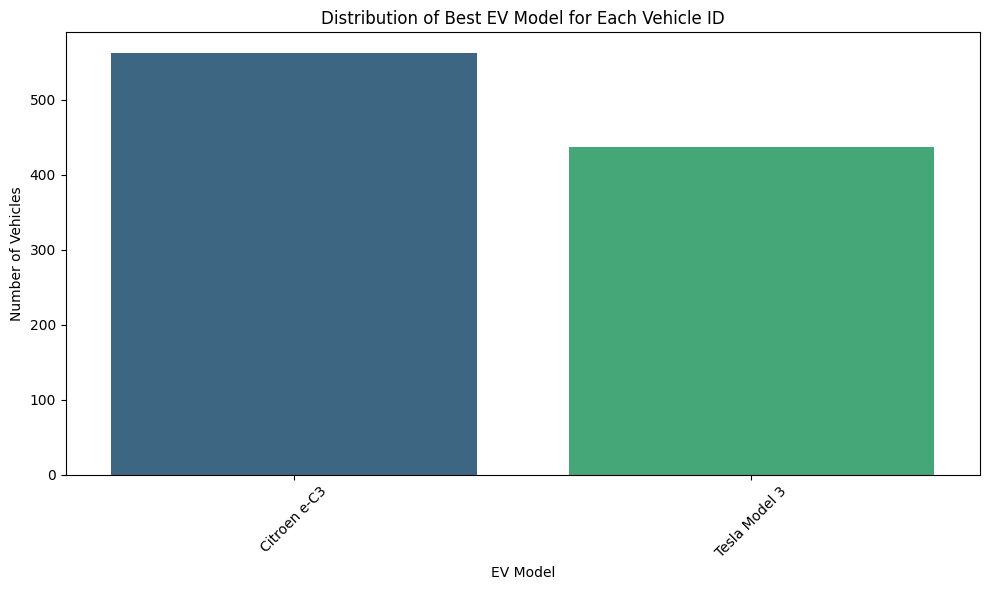

In [50]:
best_ev_df_t6 = best_ev_model_per_vehicle(sorted_results_t6)
print(best_ev_df_t6)
plot_best_ev_models(best_ev_df_t6)

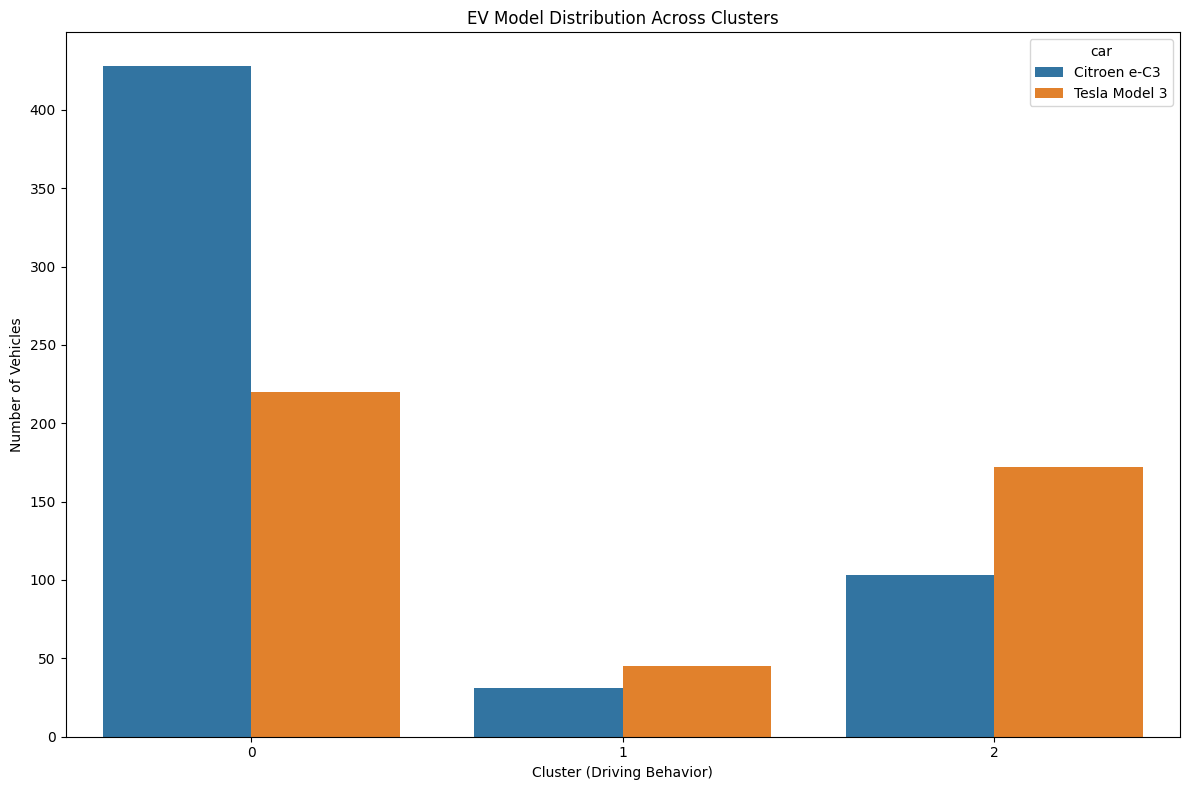

In [51]:
cluster_ev_summary_t6 = best_ev_df_t6.groupby(["cluster", "car"]).size().reset_index(name="Count")
plot_cluster_ev_summary(cluster_ev_summary_t6)

In [52]:

avg_compatibility_per_cluster = sorted_results_t6.groupby(["cluster", "car"]).agg(
    avg_compatibility_score=("Compatibility Score", "mean")
).reset_index()


print(avg_compatibility_per_cluster)


   cluster              car  avg_compatibility_score
0        0  BMW iX xDrive40                 0.716774
1        0     Citroen e-C3                 0.821054
2        0    Tesla Model 3                 0.816721
3        1  BMW iX xDrive40                 0.573775
4        1     Citroen e-C3                 0.689808
5        1    Tesla Model 3                 0.694949
6        2  BMW iX xDrive40                 0.626882
7        2     Citroen e-C3                 0.735122
8        2    Tesla Model 3                 0.740251


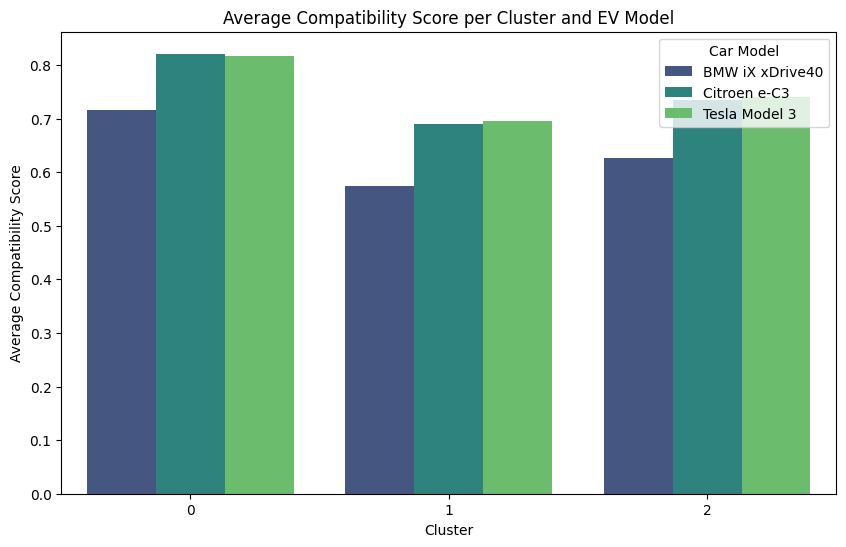

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_compatibility_per_cluster, 
    x="cluster", 
    y="avg_compatibility_score", 
    hue="car",
    palette="viridis"
)
plt.title("Average Compatibility Score per Cluster and EV Model")
plt.xlabel("Cluster")
plt.ylabel("Average Compatibility Score")
plt.legend(title="Car Model")
plt.show()